This code was used to train the OLS-3 model, which served as the baseline.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

First, based on the definition in the paper, we construct the ROS function to evaluate the model performance.

In [2]:
def r2_oos(y_true, y_pred):

    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if mask.sum() == 0:
        return np.nan
    y, yp = y_true[mask], y_pred[mask]
    rss, tss = np.sum((y - yp) ** 2), np.sum(y ** 2)
    return 1 - rss / tss if tss > 0 else np.nan

`ols_rolling_regression()` implements the annual rolling validation method based on **Gu, Kelly & Xiu (2020)**. It uses three classic firm-level features—`Size (mvel1)`, `Book-to-Market (bm)`, and `Momentum (mom12m)`—to build an OLS model and calculate out-of-sample predictive power (Out-of-Sample R²).

This function retrains the regression model annually and makes predictions for the following year, fully evaluating the model's predictive stability from 1987 to 2016.

In [6]:
def ols_rolling_regression(
    data_path="../data/processed/features1.parquet",
    train_start=1957,
    test_start=1987,
    test_end=2016,
    target="ret_excess_t_plus_1",
    features=["c_mvel1", "c_bm", "c_mom12m"]
):

    print(f" Loading dataset from {data_path} ...")


    try:
        df = pd.read_parquet(data_path)
    except FileNotFoundError:
        print(f" Warning: Data file not found at {data_path}. Using dummy data for demonstration.")
        N = 1000
        dates = pd.date_range(start=f"{train_start}-01-01", end=f"{test_end}-12-01", freq="M")
        df = pd.DataFrame({
            "month": dates,
            target: np.random.randn(len(dates)) * 0.05,
            "c_mvel1": np.random.rand(len(dates)),
            "c_bm": np.random.rand(len(dates)),
            "c_mom12m": np.random.randn(len(dates)),
        })

        for col in [target] + features:
            df.loc[df.sample(frac=0.05).index, col] = np.nan


    df["month"] = pd.to_datetime(df["month"], errors="coerce")
    df["year"] = df["month"].dt.year

    missing = [f for f in features if f not in df.columns]
    if missing:
        raise ValueError(f"Missing required features: {missing}")


    y_true_all, y_pred_all, annual_r2 = [], [], []

    for Y in range(test_start, test_end + 1):
        tr_mask = (df["year"] >= train_start) & (df["year"] <= Y - 1)
        te_mask = df["year"] == Y

        X_tr, y_tr = df.loc[tr_mask, features], df.loc[tr_mask, target]
        X_te, y_te = df.loc[te_mask, features], df.loc[te_mask, target]

        if len(X_tr) < 20 or len(X_te) == 0:
            print(f"[OLS-3] {Y}: skipped (insufficient data)")
            continue


        scaler = StandardScaler()
        imputer = SimpleImputer(strategy="median")

        X_tr_filled = imputer.fit_transform(X_tr)
        X_te_filled = imputer.transform(X_te)

        X_tr_s = scaler.fit_transform(X_tr_filled)
        X_te_s = scaler.transform(X_te_filled)


        y_tr_median = y_tr.median()
        y_tr_filled = y_tr.fillna(y_tr_median)
        y_te_filled = y_te.fillna(y_tr_median)


        ols = LinearRegression().fit(X_tr_s, y_tr_filled)
        yhat = ols.predict(X_te_s)


        y_true_all.append(y_te_filled)
        y_pred_all.append(pd.Series(yhat, index=y_te_filled.index))

        r2_y = r2_oos(y_te_filled.values, yhat)
        annual_r2.append({"year": Y, "r2_oos": r2_y})
        print(f"[OLS-3] {Y}: R²_oos = {r2_y:.6f}")


    if not y_true_all:
        print("No results generated. Check data availability.")
        return None

    y_true_all = pd.concat(y_true_all).sort_index()
    y_pred_all = pd.concat(y_pred_all).sort_index()
    df_annual = pd.DataFrame(annual_r2)
    r2_total = r2_oos(y_true_all.values, y_pred_all.values)

    print("\n" + "=" * 30)
    print(f"[OLS-3] Overall Out-of-Sample R² = {r2_total:.6f}")
    print("=" * 30)

    plt.figure(figsize=(10, 5))
    plt.plot(df_annual["year"], df_annual["r2_oos"], marker="o", label="OLS-3 Annual R²")
    plt.axhline(0, color="gray", linestyle="--", lw=1)
    plt.axhline(r2_total, color="red", linestyle="--", alpha=0.7, label=f"Overall R² = {r2_total:.4f}")
    plt.title("OLS-3 — Annual Out-of-Sample R² (1987–2016)")
    plt.xlabel("Year")
    plt.ylabel("R²_oos")
    plt.legend()
    plt.grid(alpha=0.5, linestyle="--")
    plt.tight_layout()
    plt.show()

    return df_annual, r2_total

building main function and run.

 Loading dataset from ../data/processed/features1.parquet ...
[OLS-3] 1987: R²_oos = -0.005043
[OLS-3] 1988: R²_oos = 0.002734
[OLS-3] 1989: R²_oos = -0.002911
[OLS-3] 1990: R²_oos = -0.004427
[OLS-3] 1991: R²_oos = 0.003754
[OLS-3] 1992: R²_oos = 0.003915
[OLS-3] 1993: R²_oos = 0.006103
[OLS-3] 1994: R²_oos = -0.006208
[OLS-3] 1995: R²_oos = 0.006785
[OLS-3] 1996: R²_oos = 0.004263
[OLS-3] 1997: R²_oos = 0.003437
[OLS-3] 1998: R²_oos = -0.001407
[OLS-3] 1999: R²_oos = 0.004177
[OLS-3] 2000: R²_oos = -0.000869
[OLS-3] 2001: R²_oos = 0.000605
[OLS-3] 2002: R²_oos = -0.001928
[OLS-3] 2003: R²_oos = 0.016160
[OLS-3] 2004: R²_oos = 0.002983
[OLS-3] 2005: R²_oos = 0.006769
[OLS-3] 2006: R²_oos = 0.001836
[OLS-3] 2007: R²_oos = -0.014148
[OLS-3] 2008: R²_oos = -0.015259
[OLS-3] 2009: R²_oos = 0.006603
[OLS-3] 2010: R²_oos = 0.012097
[OLS-3] 2011: R²_oos = -0.003652
[OLS-3] 2012: R²_oos = 0.008319
[OLS-3] 2013: R²_oos = 0.014351
[OLS-3] 2014: R²_oos = -0.003832
[OLS-3] 2015: R²_oos = -0.00674

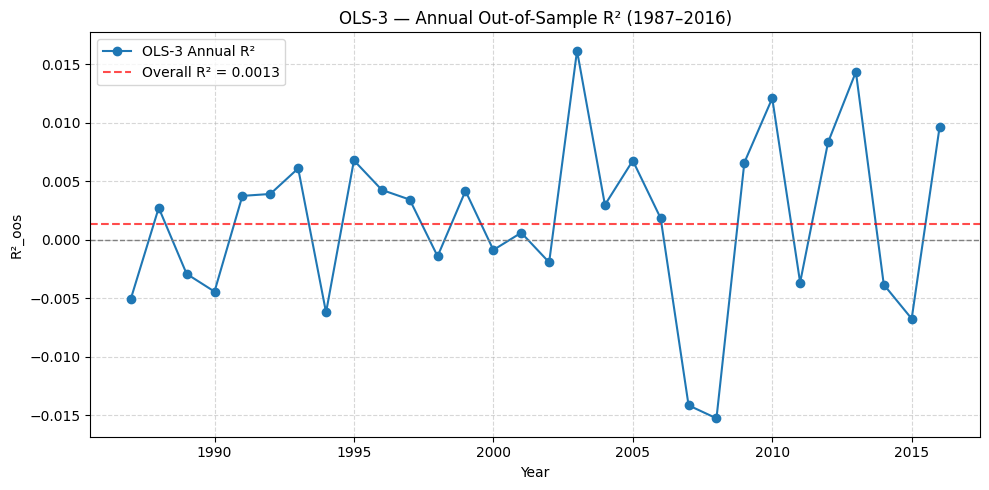

✅ Regression completed successfully.


In [7]:
def main():
    df_annual, r2_total = ols_rolling_regression()
    if df_annual is not None:
        print("✅ Regression completed successfully.")


if __name__ == "__main__":
    main()